# Results Visualization Script

This script generates some of the visualizations used in the work. The graphics can be reproduced. However, the indices are selected manually in and may provide different representations when the datasets are replaced.

## Dependencies

In [4]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize 

import numpy as np

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

from heapq import nlargest

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

## Load Models and Datasets

In [5]:
# Load all the datasets for later inspection

validation_dataset = tf.data.experimental.load("datasets/tiny_imagenet/validation/")

clean_dataset = tf.data.experimental.load("datasets/evaluation_clean/")

noise_dataset = tf.data.experimental.load("datasets/evaluation_noise/")

mi_fgsm_dataset_e4 = tf.data.experimental.load("datasets/adversarial_datasets/MI-FGSMAttack/e4/")
mi_fgsm_dataset_e8 = tf.data.experimental.load("datasets/adversarial_datasets/MI-FGSMAttack/e8/")
mi_fgsm_dataset_e16 = tf.data.experimental.load("datasets/adversarial_datasets/MI-FGSMAttack/e16/")
mi_fgsm_dataset_e32 = tf.data.experimental.load("datasets/adversarial_datasets/MI-FGSMAttack/e32/")

2022-07-11 14:03:41.555165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 14:03:42.186463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13745 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [6]:
# Load all the Models for later inspection

m_substitute = tf.keras.models.load_model("trained_models/substitute.h5")
m_target = tf.keras.models.load_model("trained_models/target.h5")
m_at = tf.keras.models.load_model("trained_models/defenses/adversarial_training/adversarial_training.h5")
m_at_sampling = tf.keras.models.load_model("trained_models/defenses/adversarial_training/adversarial_training_with_sampling.h5")
m_mad_e8 = tf.keras.models.load_model("trained_models/defenses/madry/madry_e8_n10.h5")
m_mad_e16 = tf.keras.models.load_model("trained_models/defenses/madry/madry_e16_n20.h5")
m_si_l0 = tf.keras.models.load_model("trained_models/defenses/seiler/seiler_lambda0.h5")
m_si_l10 = tf.keras.models.load_model("trained_models/defenses/seiler/seiler_lambda10.h5")
m_DD = keras.models.load_model("trained_models/defenses/defensive_distillation/defensive_distillation.h5")

## Number of Papers about adversarial examples, adversarial defenses and adversarial attacks

Figure for section 3.7 (Current Trends) about the approximate number of adversarial machine learning papers per year.

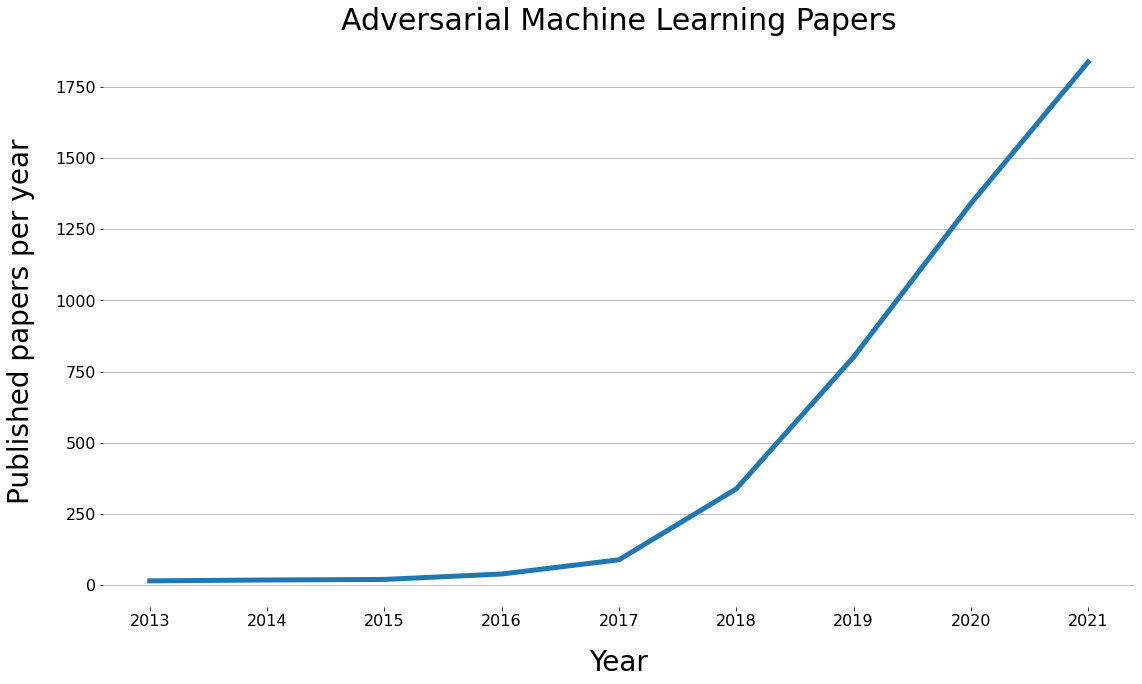

In [7]:
# only check from the 2013 paper "Intriguing properties of neural networks"
years = ["2013","2014","2015","2016","2017","2018","2019","2020","2021"]

# Source: Scopus -> Search String: "Adversarial Attack" OR "Adversarial Defense" OR "Adversarial Example"
papers = [15, 18, 20, 39, 89, 338, 801, 1340, 1837] 

figure, ax = plt.subplots()
figure.set_size_inches(18.5, 10.5)

plt.title("Adversarial Machine Learning Papers", fontsize=30)
plt.xlabel("Year", fontsize=28, labelpad=20)
plt.xticks(fontsize=16)
plt.ylabel("Published papers per year", fontsize=28, labelpad=20)
plt.yticks(fontsize=16)
plt.grid(axis = 'y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax = plt.plot(years, papers, linewidth=5)

In [218]:
#figure.savefig("figures/number_of_aml_papers.pdf", bbox_inches='tight')

## Plot five images in row

Figure for section 5. Any five images k can be selected. The concrete selection was made manually.

In [10]:
def plot_four(data, label, k=[7, 13, 31, 82, 112]):
    x, y = next(iter(data))
    x=np.clip(x, 0, 255)
    
    figure, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10.00, 5]
    plt.rcParams["figure.autolayout"] = True
    data = x[k]/255
    
    for i in range(5):
        plt.subplot(1, 6, i+1)
        plt.axis('off')
        if i==0:
            plt.text(-50, 35, label, fontsize=20)
        plt.imshow(data[i])
    
    plt.show()
    return figure

Create and save the plot for the clean and every mi-fgsm dataset:

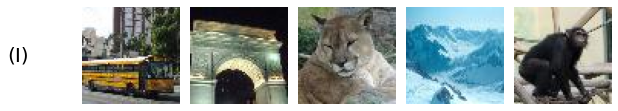

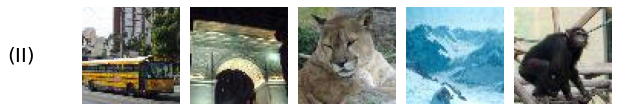

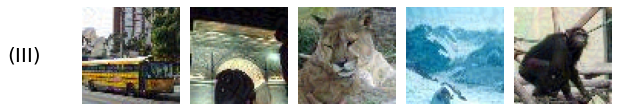

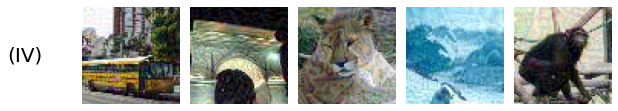

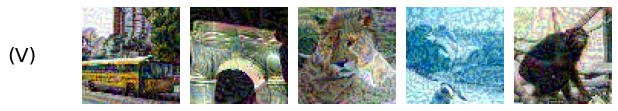

In [12]:
figure = plot_four(clean_dataset, label="(I)")
#figure.savefig("figures/image_matrix_i.pdf", bbox_inches='tight')
figure = plot_four(mi_fgsm_dataset_e4, label="(II)")
#figure.savefig("figures/image_matrix_ii.pdf", bbox_inches='tight')
figure = plot_four(mi_fgsm_dataset_e8, label="(III)")
#figure.savefig("figures/image_matrix_iii.pdf", bbox_inches='tight')
figure = plot_four(mi_fgsm_dataset_e16, label="(IV)")
#figure.savefig("figures/image_matrix_iv.pdf", bbox_inches='tight')
figure = plot_four(mi_fgsm_dataset_e32, label="(V)")
#figure.savefig("figures/image_matrix_v.pdf", bbox_inches='tight')

# Goodfellow style visualization of AEs

Insipired by Goodfellow et al., 2015 (Explaining and harnessing adversarial examples):

In [13]:
def plot_goodfellow_style(ds, ds_adv, i=0):
    
    # Rebatch boch datassets
    ds = ds.unbatch().batch(2500)
    ds_adv = ds_adv.unbatch().batch(2500)
    
    # Unpack and transform clean dataset, pick image with index i within first batch
    x, y = next(iter(ds))
    x = x[i]
    y = y[i]
    x = np.clip(x, 0, 255)

    # Unpack and transform adversarial dataset, pick image with index i within first batch
    x_adv, _ = next(iter(ds_adv))
    x_adv = x_adv[i]
    x_adv = np.clip(x_adv, 0, 255)
    
    # The total adversarial perturbation
    perturbation = x_adv-x

    # get predictions
    y_t = m_target.predict(np.expand_dims(x,0)).flatten()*100
    y_t_adv = m_target.predict(np.expand_dims(x_adv,0)).flatten()*100

    print("True class: ", np.argmax(y)+1)
    print("Target prediction (clean): ", np.argmax(y_t)+1, np.max(y_t))
    print("Target prediction (adversarial): ", np.argmax(y_t_adv)+1, np.max(y_t_adv))
    
    # The labels to the id can be looked up in the tiny-imagenet folder
    print("Class label 200 => African elephant, Loxodonta africana")
    print("Class label 42 => king penguin, Aptenodytes patagonica")

    t1 = nlargest(3,y_t.tolist())
    t2 = nlargest(3,y_t_adv.tolist())

    sorter = np.argsort(y_t)
    res = sorter[np.searchsorted(y_t, t1, sorter=sorter)]
    print(t1)
    print(res)

    sorter = np.argsort(y_t_adv)
    res = sorter[np.searchsorted(y_t_adv, t2, sorter=sorter)]
    print(t2)
    print(res)

    x /= 255
    x_adv /= 255
    
    figure, ax = plt.subplots()
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.figsize"] = [25, 20]

    plt.subplot(1, 5, 1)
    plt.axis('off')
    plt.imshow(x)
    
    plt.subplot(1, 5, 2)
    #plt.set_figwidth(15)
    plt.text(0.4, 0.5, "+ $\epsilon$ ·", fontsize=33)
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.axis('off')
    plt.imshow(perturbation)
    
    plt.subplot(1, 5, 4)
    plt.text(0.45, 0.5, "=", fontsize=33)
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.axis('off')
    plt.imshow(x_adv)
    
    plt.show()
    
    return figure

Create and save:

2022-07-11 14:07:03.129679: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class:  200
Target prediction (clean):  200 99.916756
Target prediction (adversarial):  42 99.99741
Class label 200 => African elephant, Loxodonta africana
Class label 42 => king penguin, Aptenodytes patagonica
[99.91675567626953, 0.047108449041843414, 0.005453812424093485]
[199  57  66]
[99.9974136352539, 0.0006140901823528111, 0.00036115580587647855]
[ 41 116 115]


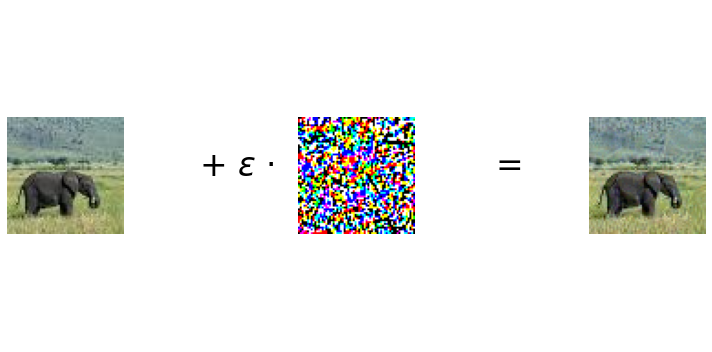

In [14]:
figure = plot_goodfellow_style(clean_dataset, mi_fgsm_dataset_e8, 134) # 134 (pick any that is intially right classified)
#figure.savefig("figures/ae_elephant.pdf", bbox_inches='tight')

## Visualize the white-box and black-box loss

In [87]:
# calculate the loss matrix (z_mesh)
def z_mesh(target, substitute, x, n=25, _min=0, _max=8, dd=False):
    
    # Use the CCE loss
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    X = np.arange(0, n, 1)
    Y = np.arange(0, n, 1)
    F = np.ndarray(shape=(n,n))
    
    E = np.arange(_min, _max, (_max-_min)/n)

    grad1=fast_gradient_method(target, x, 1, np.inf)-x
    grad2=fast_gradient_method(substitute, x, 1, np.inf)-x

    for e1 in X:
        for e2 in Y:

            x_tmp=x+E[e1]*grad1+E[e2]*grad2
            x_tmp = np.clip(x_tmp, 0, 255)

            pred=target.predict(x_tmp)
            pred=np.squeeze(pred)
            
            # When the model under investigation is defensive distillation, we have to calc the softmax first
            # DD return the logits by default
            if dd:
                pred = tf.nn.softmax(pred)
                
            F[e1][e2] = loss(y,pred)
    
    return F

# visualize the loss matrix
def loss_3d(Z, lim_low, lim_up, n=25, _min=0, _max=8, title=""):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(18.5, 10.5)
    fig.gca().invert_yaxis()
    fig.gca().invert_zaxis()
    
    plt.title(title,
              {'fontsize': 30})
    
    ax.set_xlabel('$\epsilon$ $ \cdot $ Substitute Gradient', fontsize=28, rotation=150, labelpad=10)
    ax.set_ylabel('$\epsilon$ $ \cdot $ Target Gradient', fontsize=28, labelpad=10)

    # Make data.
    X = np.arange(_min, _max, (_max-_min)/n)
    Y = np.arange(_min, _max, (_max-_min)/n)
    X, Y = np.meshgrid(X, Y)

    normalize = Normalize(vmin=lim_low, vmax=lim_up)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True, norm=normalize)

    # Customize the z axis.
    ax.set_zlim(lim_low, lim_up)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    #fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    return fig

In [147]:
idx = 20 #  just pick one index between 0 and 119 that is initially right classified(batch size)
x, y = next(iter(clean_dataset)) 
x, y = np.expand_dims(x[idx], 0), y[idx]

n=20 # total n*n datapoints per figure
_min=-1 # minimum X/Y value
_max=16 # maximum X/Y value
lim_low=0 # lower limit for z value
lim_up=16 # upper limit for z value

### Target

In [148]:
loss_target = z_mesh(m_target, m_substitute, x, n, _min, _max)

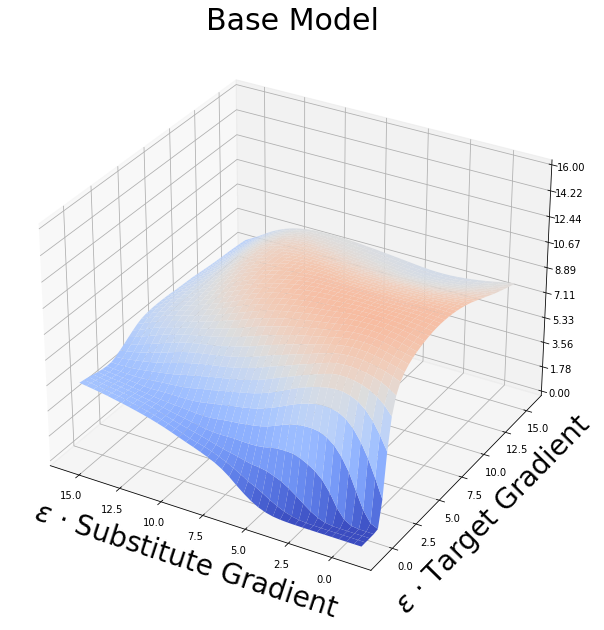

In [149]:
figure = loss_3d(loss_target, lim_low, lim_up, n, _min, _max, title="Base Model")

In [100]:
# figure.savefig("figures/base.pdf", bbox_inches='tight')

### Adversarial Training

In [150]:
loss_adversarial_training = z_mesh(m_at, m_substitute, x, n, _min, _max)

In [ ]:
loss_adversarial_training = z_mesh(m_at, m_substitute, x, n, _min, _max)
figure = loss_3d(loss_adversarial_training, lim_low, lim_up, n, _min, _max, "Adversarial Training with $\epsilon=16$")

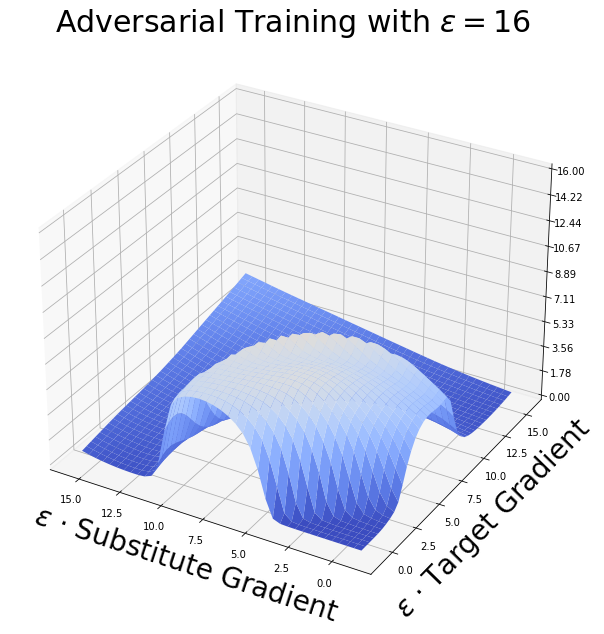

In [151]:
figure = loss_3d(loss_adversarial_training, lim_low, lim_up, n, _min, _max, "Adversarial Training with $\epsilon=16$")

In [89]:
# figure.savefig("figures/at.pdf", bbox_inches='tight')

### Adversarial Training $\epsilon \sim U(0,32)$

In [152]:
loss_adversarial_training_sampling = z_mesh(m_at_sampling, m_substitute, x, n, _min, _max)

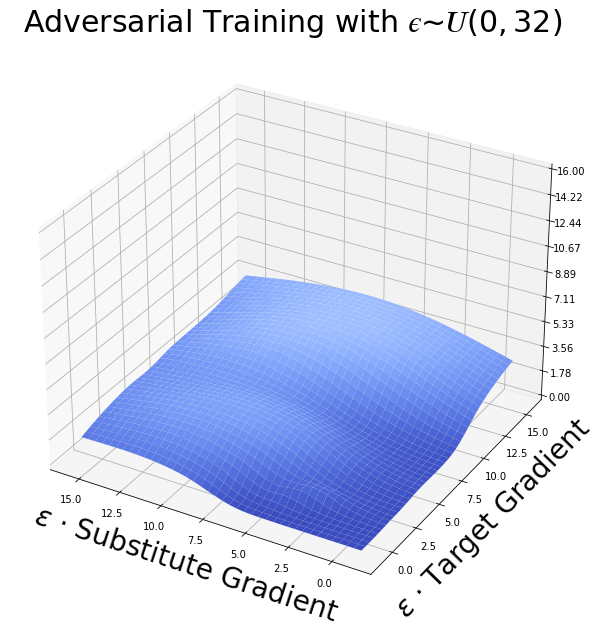

In [153]:
figure = loss_3d(loss_adversarial_training_sampling, lim_low, lim_up, n, _min, _max, "Adversarial Training with $𝜖∼𝑈(0,32)$")

In [91]:
# figure.savefig("figures/at_sampling.pdf", bbox_inches='tight')

### Madry defense

In [154]:
loss_madry = z_mesh(m_mad_e16, m_substitute, x, n, _min, _max)

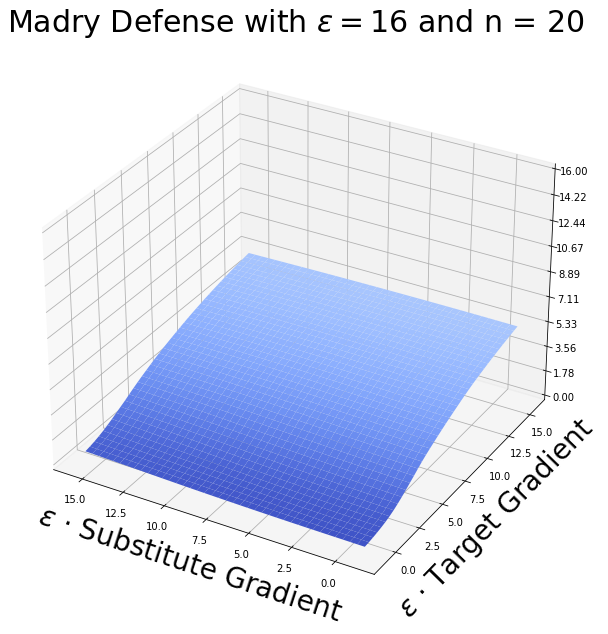

In [155]:
figure = loss_3d(loss_madry, lim_low, lim_up, n, _min, _max, "Madry Defense with $\epsilon=16$ and n = 20")

In [94]:
# figure.savefig("figures/madry.pdf", bbox_inches='tight')

### Superimposing with $\tau=10$

In [156]:
loss_superimposing = z_mesh(m_si_l10, m_substitute, x, n, _min, _max)

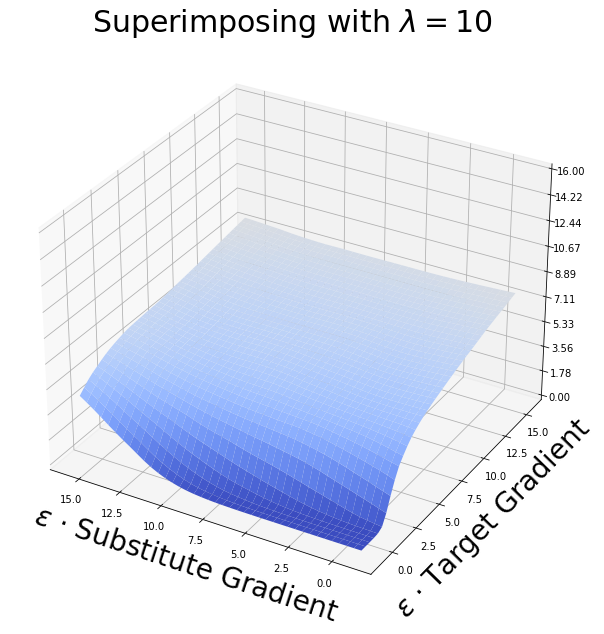

In [157]:
figure = loss_3d(loss_superimposing, lim_low, lim_up, n, _min, _max, "Superimposing with $\lambda=10$")

In [96]:
# figure.savefig("figures/superimposing_regularized.pdf", bbox_inches='tight')

### Defensive Distillation

In [158]:
loss_defensive_distillation = z_mesh(m_DD, m_substitute, x, n, _min, _max, dd=True)

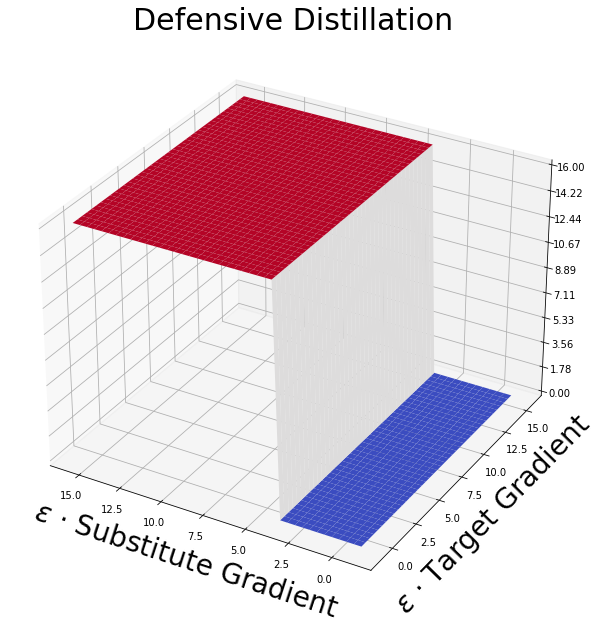

In [159]:
figure = loss_3d(loss_defensive_distillation, lim_low, lim_up, n, _min, _max, "Defensive Distillation")

In [98]:
# figure.savefig("figures/defensive_distillation.pdf", bbox_inches='tight')